<a href="https://colab.research.google.com/github/rafmacalaba/Credit-Scoring-Kaggle-Competition/blob/master/Open_Source_AI_LLM_Models_%26_Tools_for_Text_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!-- # GISTEmbed Models: AI Models as Global Public Good -->
# Open Source AI/LLM Models & Tools for Text Data Analysis

**Produced by**  
Aivin Solatorio (Program Manager - AI for Data | asolatorio@worldbank.org | aifordata@worldbank.org)  
_Development Data Group & Office of the Chief Statistician, World Bank_

---

## 📖 Overview

This notebook demonstrates how to use **AI models and methods** to produce text embeddings to uncover structure in a corpus of documents (but really anything that has text!). An **open source LLM** will also be used to automate the labeling of the topics/clusters.

This task covers a wide range of foundational techniques that __can be applied to various contexts__ not just with documents.

In summary, we will:

1. Identify a data source and scrape the metadata.
2. Introduce the **GISTEmbed** model  
3. Generate embeddings for a document collection  
4. Implement semantic search  
5. Implement dimensionality reduction
6. Perform clustering to organize structure
7. Explore how to leverage Open LLMs to auto-annotate topics/clusters
8. Visualize the embedding space  

ℹ️ Bonus: Try out prompting the open source LLM at the end of the notebook.

---

### Throughout the course of this notebook...

I would like you to identify potential applications to your use case, beyond documents. Example:

- How might we use embeddings to organize survey questions or find related survey questions?
- Can we use the same pipeline to also understand the thematic groups of indicators in the WDI? How about in Data360?
- How might we use embeddings to identify indicator descriptions that are likely to have less quality?
- How might we improve knowledge discovery using semantic search?
- How might we use embeddings to bridge the gap between English and low-resource languages?
- Can embeddings represent inputs to ML models for small area estimation? How about food security prediction? Classifying jobs?
- Can we improve the experience of the Data HelpDesk by using embeddings to find likely answers to user questions?
- Can I use open LLMs to help me annotate data and documents that are classified for public access?

<!--
---

## 📑 Table of Contents

1. [Prerequisites](#prerequisites)  
2. [Installation](#installation)  
3. [Loading the Data](#loading-the-data)  
4. [Generating Embeddings](#generating-embeddings)  
5. [Visualizing Embeddings](#visualizing-embeddings)  
6. [Semantic Search](#semantic-search)  
7. [Clustering & Topic Annotation](#clustering--topic-annotation)  
8. [Conclusion](#conclusion)   -->

---

### So what you'll get at the end of this guide?

A fully functioning interactive data map of the documents by thematic groups. A preview is shown in the image below 👇🏽.

And... hopefully some spark of inspiration that will move us closer to **democratizing** and advancing **AI literacy** across the team!

![Badge](https://hitscounter.dev/api/hit?url=https%3A%2F%2Fcolab.research.google.com%2Fdrive%2F1XudvpG8pYrAiGANn_mMNJzDOmlataXQB&label=&icon=globe2&color=%23198754)

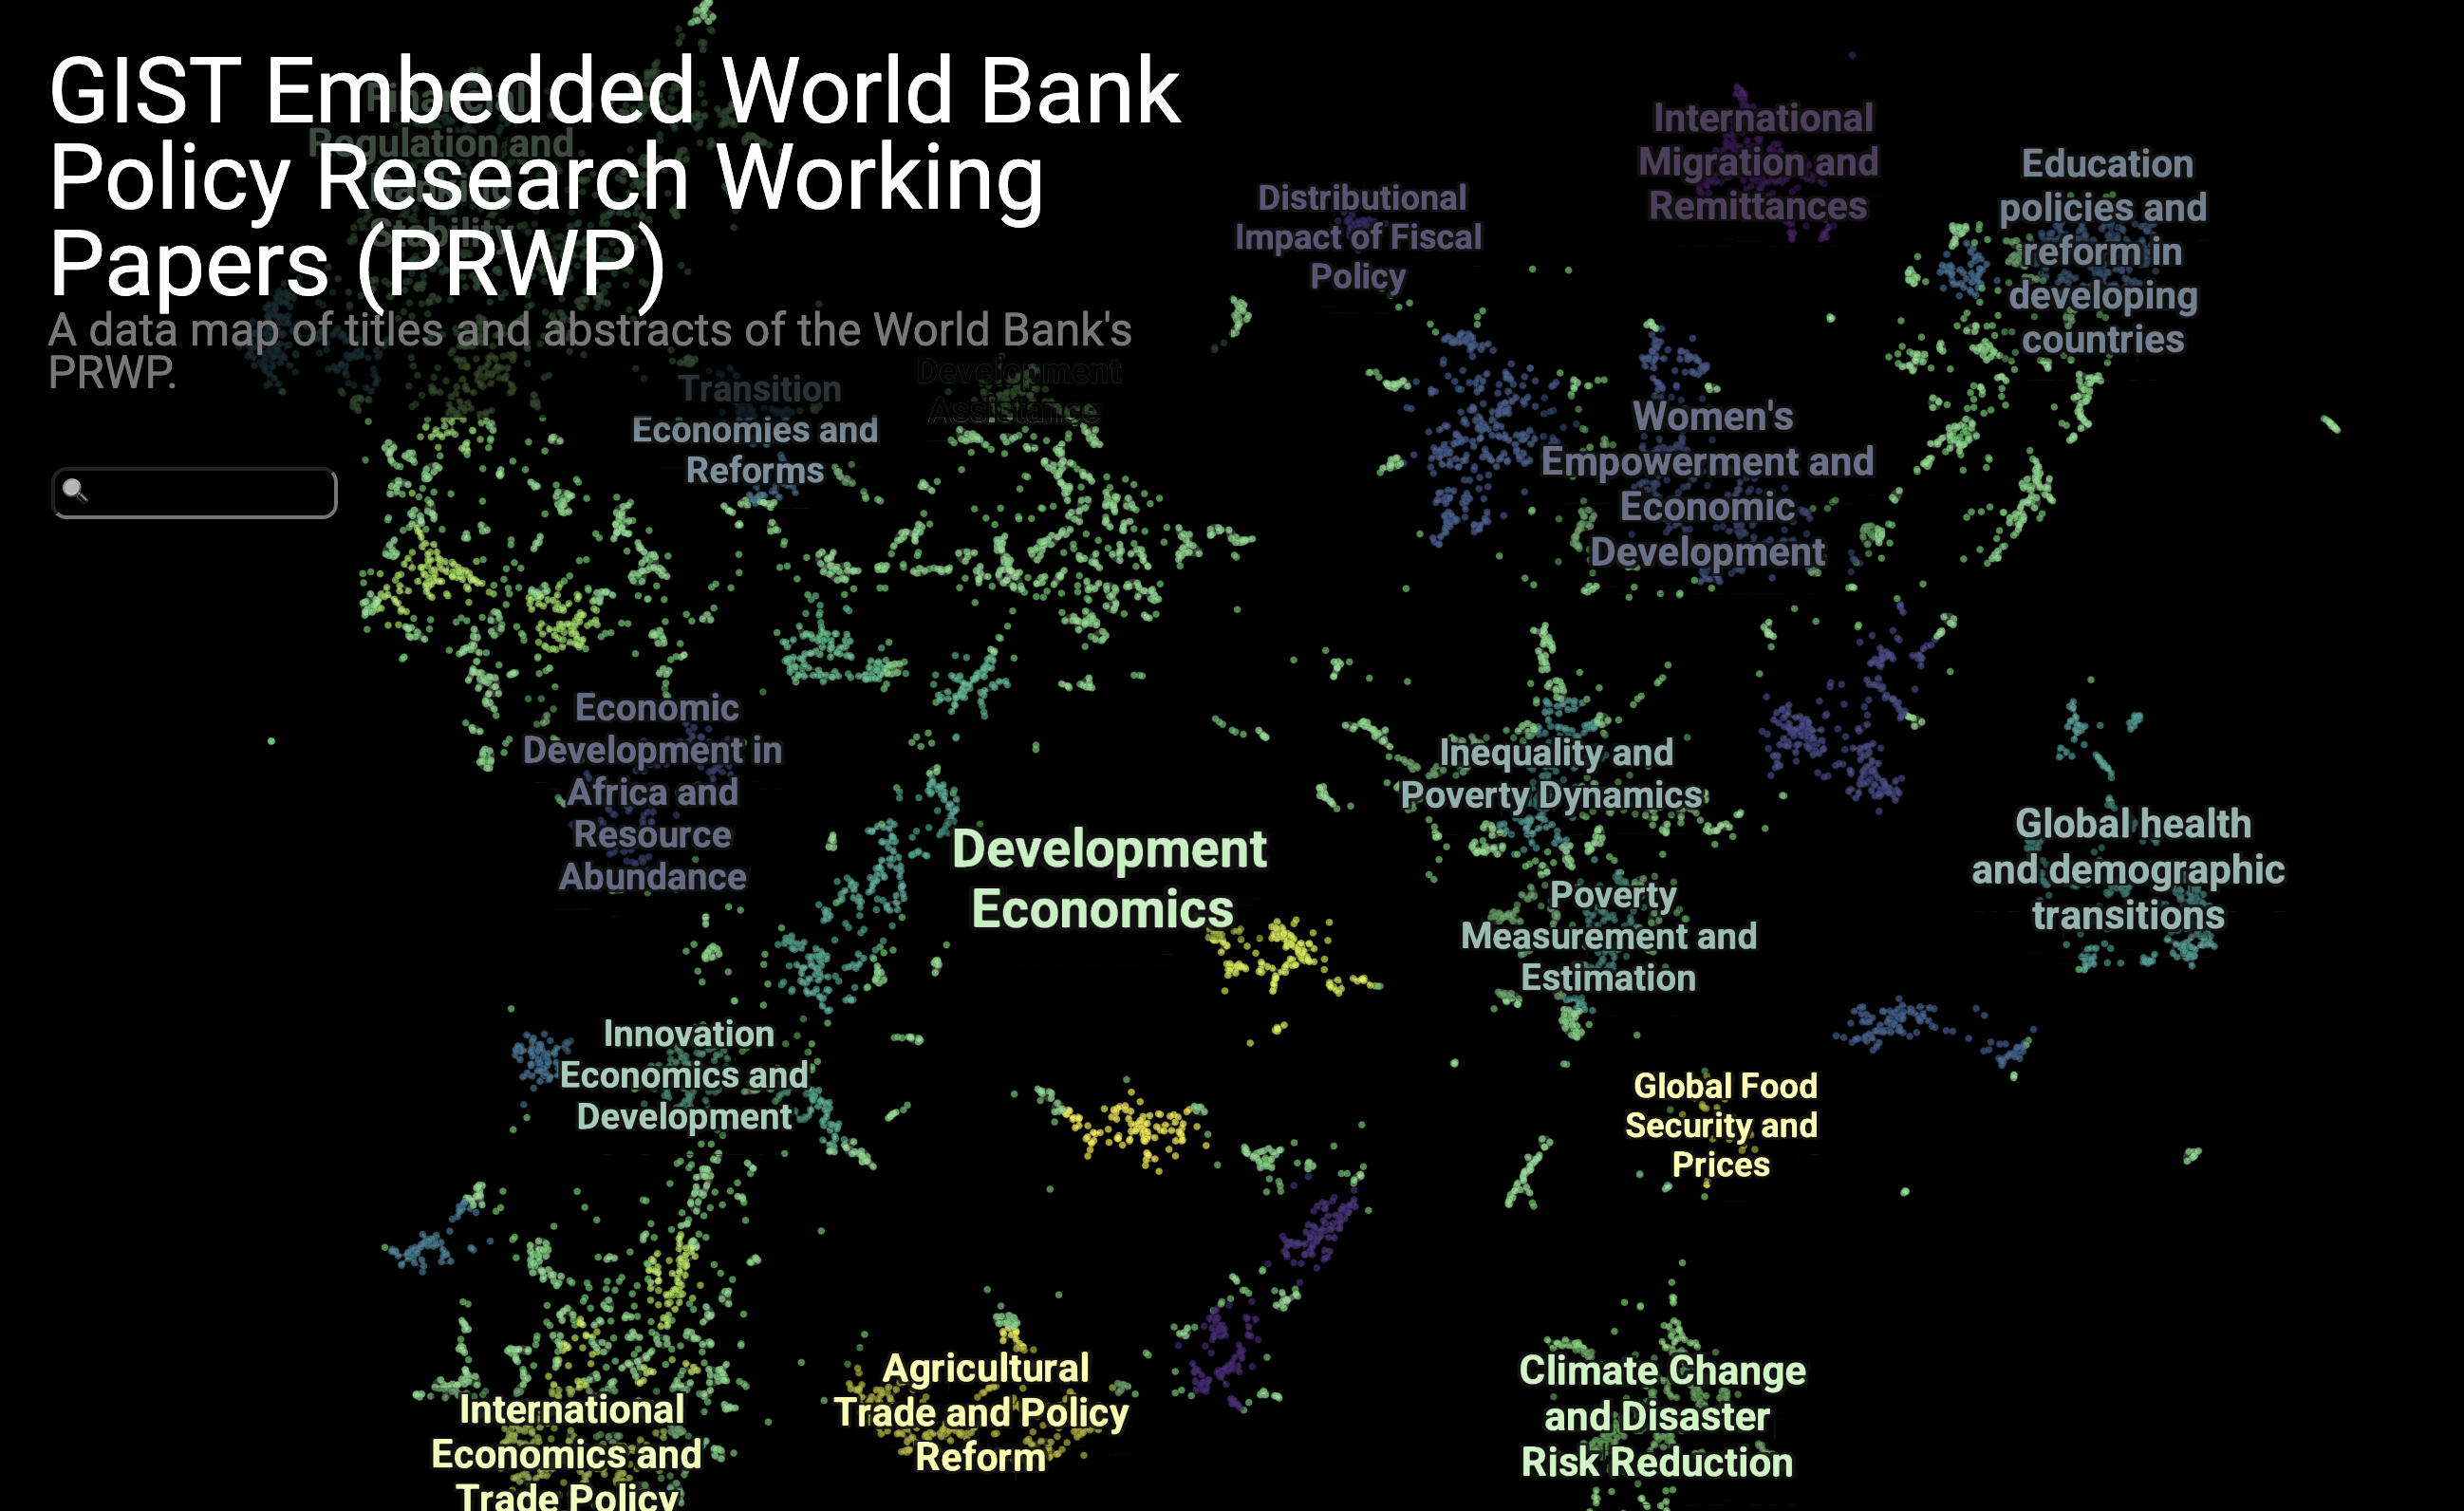

In [ ]:
%%capture
# Install the dependencies
# FYI: this could take about 5 minutes...
!pip install datamapplot hf_xet # flash_attn torch vllm "bitsandbytes>=0.45.3"

# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install unsloth

# Get latest Unsloth
!pip install --upgrade --no-deps "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

In [ ]:
import warnings

# Let's suppress warnings for now.
warnings.filterwarnings('ignore')

In [ ]:
%%capture
# Import all libraries here. This could take a while, too...
import json
import numpy as np
import pandas as pd
import re
import requests
import os

from IPython.display import Markdown
from tqdm.auto import tqdm

# Dimensionality reduction
import umap

# Clustering
import hdbscan

# Create interactive cluster map
import datamapplot

# Open source LLM
# Make sure unsloth is loaded first before the transformers library (in case).
from unsloth import FastLanguageModel
from unsloth.chat_templates import get_chat_template
from transformers import TextStreamer

# For graphing and formatting
import seaborn as sns
from matplotlib.colors import rgb2hex
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm as cmx

# For the embedding model
from sentence_transformers import SentenceTransformer

## Collect World Bank's PRWP Metadata from the Documents and Reports API


The Bank has a vast collection of publicly available documents; a subset of which is the **Policy Research Working Papers (PRWP)**. The PRWP is a collection of policy focused documents and has a broad thematic coverage. We will use it as a material for this guide.

> **Note**: The entire guide can work for any collection of textual content, requiring on very minor changes. It may also be applied to other modalities once embeddings have been computed, e.g., satellite images, voice recordings, etc.

In [ ]:
# Define the base URL
BASE_URL = "https://search.worldbank.org/api/v2/wds"


def fetch_prwp_metadata(os: int = 0, rows: int = 1000, order: str = "asc", get_total: bool = False):
    """
    Fetch the metadata for the World Bank's Policy Research Working Papers.

    :param os: The offset.
    :param rows: The number of rows to return.
    :param order: The order to return the rows in.
    :param get_total: Whether to return the total number of rows.

    :return: The metadata for the World Bank's Policy Research Working Papers.
    """

    assert order in ("asc", "desc")

    # Define the query parameters as a dictionary
    params = {
        "format": "json",
        # "fct": "docty_exact,count_exact,lang_exact,disclstat_exact",
        "order": "desc",
        "rows": rows,
        "apilang": "en",
        "os": os,
        "srt": "docdt",
        "order": order,
        "lang_exact": "English",
        "docty_exact": "Policy Research Working Paper"
    }

    # Make the GET request
    response = requests.get(BASE_URL, params=params)

    # Check if the request was successful
    if response.status_code == 200:
        data = response.json()
    else:
        print(f"Error: {response.status_code}, {response.text}")
        return None

    total = data["total"]

    if get_total:
        print(f"Total: {total}")
        return total

    docs = data["documents"]
    docs.pop("facets", None)

    return data["documents"]

In [ ]:
%%time

# We actually scrape the metadata here.
metadata = {}
total = fetch_prwp_metadata(get_total=True)

offset = 0
rows = 1000
last_size = 0

while len(metadata) < total:
    out = fetch_prwp_metadata(os=offset, rows=rows)
    metadata.update(out)

    offset += rows

    if offset > total:
        break

    if len(metadata) < (last_size + rows):
        # In the interest of this demo, we just terminate
        # the scraping in case the expected rows of data is not
        # met.
        break

    last_size = len(metadata)

print(len(metadata))

Total: 10931
10931
CPU times: user 2.5 s, sys: 221 ms, total: 2.72 s
Wall time: 40.5 s


## Generate embeddings

Here, we generate the embeddings from a general purpose embedding model. This model will **convert the text** (abstract) of the document into a **list of numbers** (vectors).

These vectors encode **semantic information** from the texts, allowing us to analyse and use them into downstream applications, such as visualization, machine learning models, and identifying relevant contexts for LLMs through semantic search.

We will be using the *GIST-small-Embedding-v0* for this application. It is one of the low-resource embedding models that can run even in the user's web browsers.

> 💡Did you know: [**GISTEmbed**](https://huggingface.co/collections/avsolatorio/gistembed-66fb45a868fb2a741073b4bf) is one of the first World Bank (DECDG) “AI Models as a Global Public Good” solutions for text embeddings, with millions of global downloads and top benchmark performance. It includes models that work in low-resource technology settings.


In [ ]:
%%capture
# This part downloads the embedding model from HuggingFace.
# In case a pop-up will ask for a secret, just cancel/close it. That is not needed for open models.
model = SentenceTransformer("avsolatorio/GIST-small-Embedding-v0", use_auth_token=False)

In [ ]:
def get_content(metadata: dict):
    """
    Extract the content from the metadata. We use the title and the abstract.

    :param metadata: The metadata.

    :return: The content.
    """
    title = re.sub(r'\s+', ' ', metadata["display_title"])
    content = title + "\n\n"

    if "abstracts" in metadata:
        abstract = metadata["abstracts"]['cdata!']
        content += re.sub(r'\s+', ' ', abstract)

    return content.strip()

In [ ]:
# Here, we are structuring the content that we will pass to the embedding model.
# Currently, we consider the document title and the abstract from the metadata.

doc_contents = {k: get_content(v) for k, v in tqdm(metadata.items())}
doc_ids = list(doc_contents.keys())

# This line generates the embeddings given the text content.

embeddings = model.encode(list(doc_contents.values()), batch_size=32, show_progress_bar=True)

  0%|          | 0/10931 [00:00<?, ?it/s]

Batches:   0%|          | 0/342 [00:00<?, ?it/s]

## Semantic search using cosine similarity

A powerful application of embeddings is **semantic search**. It provides a means to find relevant data and resources that outperforms traditional keyword search. It uses the semantic information learned by the AI model during its training to understand meaning of texts.

**Cosine similarity** has been the popular measure to assess relevance. There are other similarity metrics that may be explored, too, e.g., euclidean distance.

Below, we demonstrate how we can easily implement semantic search over the document titles/abstracts that we have generated embeddings for. Because we are using a small model, the quality of the embeddings may still be sub optimal but arguably already offers better results than just using keywords.

In [ ]:
# NOTE: Semantic search works optimally with more contextual queries.
# Try changing the query and see what document titles are most closest to the query.
query = "How can we measure the impact of covid 19?"

q_embedding = model.encode(query)
sim_scores = model.similarity(q_embedding, embeddings)

for rank, ix in enumerate(sim_scores.flatten().argsort(descending=True)[:10]):
    ix = ix.cpu().item()
    title = re.sub(r'\s+', ' ', metadata[doc_ids[ix]]["display_title"])
    print(f"{rank + 1}. {title}")

1. Measuring the Economic Impact of COVID-19 with Real-Time Electricity Indicators
2. The Evolving Socioeconomic Impacts of COVID-19 in Four African Countries
3. When the Lights Go Out : The Economic Impacts of Covid-19 on Cities Globally
4. Winners and Losers from COVID-19 : Global Evidence from Google Search
5. The Sooner, the Better : The Early Economic Impact of Non-Pharmaceutical Interventions during the COVID-19 Pandemic
6. Unmasking the Impact of COVID-19 on Businesses : Firm Level Evidence from Across the World
7. Relevance of the World Bank Group’s Early Response to COVID-19 : A Cross-Country Sector Analysis
8. Synthesis of the Impacts of Covid-19 on India’s Labor Market : Looking at People, Places and Policies
9. Socioeconomic Impacts of COVID-19 in Four African Countries
10. The Short-Term Impacts of COVID-19 on Households in Developing Countries : An Overview Based on a Harmonized Data Set of High-Frequency Surveys


## Clustering: UMAP for topological compression

Since embeddings tend to "live" in high dimensions, we often apply dimensionality reduction for some downstream applications—in this case, clustering.

To learn more about the method we will use below, you may read this "old-but-gold" resource about UMAP, the intuition behind it, and theoretical underpinnings: https://pair-code.github.io/understanding-umap/.

In [ ]:
umap_model = umap.UMAP(
    # The size of local neighborhood (in terms of number of neighboring sample points) used for
    # manifold approximation.
    # Larger values result in more global views of the manifold, while smaller values result in
    # more local data being preserved. In general values should be in the range 2 to 100.
    n_neighbors=50,

    # The dimension of the space to embed into.
    # This defaults to 2 to provide easy visualization, but can reasonably be set to any
    # integer value in the range 2 to 100.
    n_components=2,

    min_dist=0.0,
    negative_sample_rate=50,
    metric='cosine',
    random_state=1029  # For reproducibility - to prevent stochastic behaviour of UMAP.
    # n_jobs=128,
)

umap_model

UMAP(metric='cosine', min_dist=0.0, n_neighbors=50, negative_sample_rate=50, random_state=1029)

In [ ]:
%%time
# Fit and transform the high-dimensional embeddings into their corresponding 2-dimensional compressed vectors.
# Takes about 2 mins in Google Colab. :)

u_embeddings = umap_model.fit_transform(embeddings)

CPU times: user 1min 57s, sys: 1.88 s, total: 1min 59s
Wall time: 2min 15s


## Clustering: Using HDBSCAN

Here we cluster the dimensionality-reduced data. HDBSCAN has nice properties compared to other clustering methods, including identification of out-of-cluster samples.

You may read more about the technique here: https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html

In [ ]:
%%time

hdbscan_model = hdbscan.HDBSCAN(
    # Control the number of topics with this parameter.
    # The minimum size of clusters; single linkage splits that contain fewer points than
    # this will be considered points "falling out" of a cluster rather than a cluster splitting
    # into two new clusters.
    min_cluster_size=50,

    metric='l2',
    cluster_selection_method='leaf',
    prediction_data=True,
)

clusters = hdbscan_model.fit_predict(u_embeddings)
cluster_ids = np.unique(clusters)

print("Number of clusters detected:", len(cluster_ids))

Number of clusters detected: 47
CPU times: user 327 ms, sys: 2 ms, total: 329 ms
Wall time: 329 ms


In [ ]:
# Here we structure the input for the visualization of the results.
# Presenting the output of the methods we have down so far visually would help us easily highlight the structure of the data.

# This will be what's shown when we later hover over a point in the graph.
hover_text = [i for i in doc_contents.values()]
# hover_text = [i.split("\n\n")[0] for i in doc_contents.values()]

# We extract some metadata here. We assume the doc_contents were generated as "<title>\n\n<abstract>".
titles = [i.split("\n\n")[0] for i in doc_contents.values()]
abstracts = [i.split("\n\n")[-1] if len(i.split("\n\n")) > 1 else "" for i in doc_contents.values()]
labels = [str(i) for i in clusters]

# Extract the additional information that we will later pass to our interactive visualization of the clusters.

extra_point_data = pd.DataFrame(list(metadata.values()))
extra_point_data["title"] = titles
extra_point_data["cluster"] = clusters
extra_point_data["abstract"] = abstracts

## Clustering: Open source LLM for cluster labeling

In this example, we use the [Qwen 2.5](https://huggingface.co/collections/Qwen/qwen25-66e81a666513e518adb90d9e) model optimized through quantization by [Unsloth](https://huggingface.co/unsloth/Qwen2.5-3B-Instruct-unsloth-bnb-4bit). This model will allow us to generate the most likely cluster or thematic labels automatically.

In [ ]:
%%time
%%capture

# Load the open source LLM using unsloth
llm_model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen2.5-3B-Instruct-unsloth-bnb-4bit",
    max_seq_length = 8192,
    load_in_4bit = True,
)

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "qwen2.5",
)

llm_model = FastLanguageModel.for_inference(llm_model) # Enable native 2x faster inference


def run_llm(messages, max_new_tokens: int = 512, streaming: bool = False):
    """
    Run the LLM on the given messages.

    :param messages: The messages to run the LLM on.
    :param max_new_tokens: The maximum number of new tokens to generate.
    :param streaming: Whether to stream the output.

    :return: The generated text.
    """
    inputs = tokenizer.apply_chat_template(messages, tokenize = True, add_generation_prompt = True, return_tensors = "pt").to("cuda")

    if not streaming:
        o = llm_model.generate(input_ids = inputs, max_new_tokens = max_new_tokens, use_cache = True)

        return tokenizer.batch_decode(o)[0].split("<|im_start|>assistant")[-1].replace("<|im_end|>", "")
    else:
        text_streamer = TextStreamer(tokenizer)
        _ = llm_model.generate(input_ids=inputs, streamer=text_streamer, max_new_tokens=max_new_tokens, use_cache=True)

CPU times: user 18.3 s, sys: 16.3 s, total: 34.5 s
Wall time: 1min 3s


In [ ]:
%%time
# Let's segue a bit and try the LLM's analytical capability by asking it to solve an algebraic problem.
# The answer should be x = 2.

test_messages = [
    {"role": "system", "content": "You are a helpful AI assistant."},
    # {"role": "user", "content": "Can you provide ways to eat combinations of bananas and dragonfruits?"},
    # {"role": "assistant", "content": "Sure! Here are some ways to eat bananas and dragonfruits together: 1. Banana and dragonfruit smoothie: Blend bananas and dragonfruits together with some milk and honey. 2. Banana and dragonfruit salad: Mix sliced bananas and dragonfruits together with some lemon juice and honey."},
    # {"role": "user", "content": "What about solving an 2x + 3 = 7 equation?"},
    {"role": "user", "content": "Can you solve the equation 2x + 3 = 7?"},
]

Markdown(run_llm(test_messages))

CPU times: user 9.8 s, sys: 398 ms, total: 10.2 s
Wall time: 15.6 s



Sure, I can help you solve that equation step by step.

The equation is:
\[ 2x + 3 = 7 \]

Step 1: Subtract 3 from both sides of the equation to isolate the term with \( x \).
\[ 2x + 3 - 3 = 7 - 3 \]
\[ 2x = 4 \]

Step 2: Divide both sides by 2 to solve for \( x \).
\[ \frac{2x}{2} = \frac{4}{2} \]
\[ x = 2 \]

So, the solution to the equation \( 2x + 3 = 7 \) is \( x = 2 \).

In [ ]:
# This function, in case you are able to provide an OPENAI_API_KEY, will
# allow you to use it for generating the cluster labels instead of the open source LLM.

def openai_llm(model: str = "gpt-4o-mini", temperature: float = 0):
    """
    Wraps a function that generates cluster labels using the OpenAI API.

    :param model: The model to use for generating the cluster labels.
    :param temperature: The temperature to use for generating the cluster labels.

    :return: A function that takes in a list of messages and returns a string.
    """
    import openai
    from google.colab import userdata

    client = openai.Client(
        api_key=userdata.get("OPENAI_API_KEY"),
    )

    def _func(messages):
        r = client.chat.completions.create(
            messages=messages,
            model=model,
            temperature=temperature,
            seed=1029,
        )

        return r.choices[0].message.content

    return _func

### Define the system prompt for the cluster labeling task.

In [ ]:
CLUSTER_LABEL_PROMPT = """You are given a list of sample document titles representing a cluster.

Provide the most relevant cluster label that best represent the documents.

Only give the cluster label and nothing else, no explanation."""


def get_cluster_titles(cluster_id, n=50, random_state=1029):
    """
    Get the titles of the documents in a cluster. This is used as the input for the LLM in the cluster labeling task.

    :param cluster_id: The cluster ID.
    :param n: The number of titles to return.
    :param random_state: The random state.

    :return: A list of titles.
    """
    sample = extra_point_data.loc[extra_point_data["cluster"] == cluster_id, "title"]
    titles = sample.sample(min(len(sample), n), random_state=random_state).tolist()

    return titles

### Generate the cluster labels using the LLM

In [ ]:
%%time
# Select which one model to use for the labeling. Only works if you have the OpenAI key.

# llm_generator = openai_llm()
llm_generator = run_llm

label_code_label = {}

for c in tqdm(cluster_ids):
    l = str(c)
    titles = get_cluster_titles(c, n=100)

    messages = [
        {"role": "system", "content": CLUSTER_LABEL_PROMPT},
        {"role": "user", "content": json.dumps(titles)}
    ]

    label_code_label[l] = run_llm(messages)

  0%|          | 0/47 [00:00<?, ?it/s]

CPU times: user 39.2 s, sys: 683 ms, total: 39.8 s
Wall time: 50.1 s


In [ ]:
# Show the list of cluster labels
Markdown("\n".join(label_code_label.values()))


Globalization and Development Economics

Pension Reform and Policy Analysis

International Migration and Remittances

Child Nutrition and Health in Developing Countries

Health economics and policy in developing countries

Climate Change and Disaster Risk Management

Water Resource Management and Governance

COVID-19 Impacts and Adaptations

Global Food Security and Prices

International Agricultural Trade and Policy Reform

Urbanization and Development

Deforestation and Biodiversity Conservation

Agricultural Development and Productivity in Sub-Saharan Africa

Land Institutions and Land Markets

Fiscal Policy and Inequality Analysis

Transportation Economics and Logistics

Infrastructure economics and policy

Refugees and Conflict Studies

Economic Growth and Development

Women's Empowerment and Economic Development

Labor market dynamics and policies in developing economies

Education Policy and Reform

Education and Economic Growth

Globalization and Foreign Direct Investment Studies

Transition Economics and Reforms

Services Trade Policy and Liberalization

Public Debt Management

Environmental Policy and Regulation

Climate Policy and Mitigation Strategies

Energy Access and Policy Analysis

Income Inequality and Its Effects

Poverty Measurement and Analysis

Productivity Growth and Efficiency Dynamics across the World

Technology and Digital Transformation in Developing Economies

Innovation and Development

Corruption in Economic Development

Tax Policy and Administration in Developing Countries

Financial Regulation and Policy Implications

Finance and Growth Literature

Microfinance and Financial Inclusion

Development Economics and Governance

International Development Economics

Financial Globalization and Capital Flows

Fiscal policy and public finances in developing countries

Inflation Economics

Export Dynamics and Product Variety in Developing Countries

International Trade and Tariffs

## Clustering: Visualize the data

In [ ]:
# This allows us to assign nice colors to the clusters.

cMap = plt.get_cmap('RdBu_r')
cNorm  = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cMap)

custom_color_map = dict(
    zip(
        np.unique(labels),
        map(rgb2hex, sns.color_palette("viridis", len(np.unique(labels))))
    )
)
custom_color_map["-1"] = "#33333355"

> ⚠️ **NOTE**: The resulting data map is interactive. You can zoom and drag it to explore. Hover over the points, which represent the documents, to see the title and abstract. Clicking on the point will open the source page for the document.

<InteractiveFigure width=100% height=800>
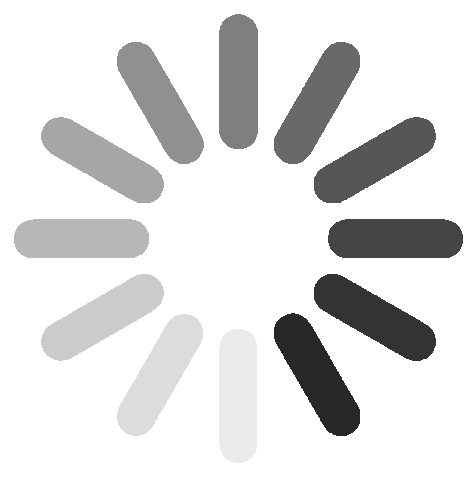

In [ ]:
# Generate the interactive data map plot and save as HTML for offline use.

data_map = u_embeddings
hover_text_html_template = """<h4>{title}</h4><p>{abstract}</p>"""

plot = datamapplot.create_interactive_plot(
    data_map,
    list(map(label_code_label.get, labels)),

    hover_text=True,
    hover_text_html_template=hover_text_html_template,

    title="GIST Embedded World Bank Policy Research Working Papers (PRWP)",
    sub_title="A data map of titles and abstracts of the World Bank's PRWP.",

    darkmode=True,
    initial_zoom_fraction=0.8,

    label_color_map={label_code_label[k]: custom_color_map[k] for k in custom_color_map},

    cluster_boundary_polygons=True,
    cluster_boundary_line_width=4,

    extra_point_data=extra_point_data[["url", "title", "abstract"]],

    on_click="window.open(`{url}`)",

    enable_search=True,
    height=800,
)

plot.save("gist-small-prwp.html")

plot

# Extra


In [ ]:
# We set this to wrap the streaming output.
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

## Test some prompts with the LLM!

In [ ]:
%%time
# <Change this prompt to your own!>
PROMPT = "What is the WDI?"

e_messages = [
    {"role": "system", "content": "You are a helpful AI assistant."},
    {"role": "user", "content": PROMPT},
]

run_llm(e_messages, streaming=True)

<|im_start|>system
You are a helpful AI assistant.<|im_end|>
<|im_start|>user
What is the WDI?<|im_end|>
<|im_start|>assistant
WDI stands for World Development Indicators, which is a database published by the World Bank that provides quantitative development indicators for more than 200 countries and areas. These indicators cover various aspects of economic and social development, including health, education, poverty, infrastructure, and more.

The World Development Indicators (WDI) provide key statistics on social, economic, and environmental development indicators for over 200 countries and areas. It includes data from the World Bank's multiple datasets, offering a comprehensive overview of global development trends.<|im_end|>
CPU times: user 8.31 s, sys: 43.9 ms, total: 8.35 s
Wall time: 10.1 s


# THE END

Try experimenting now!